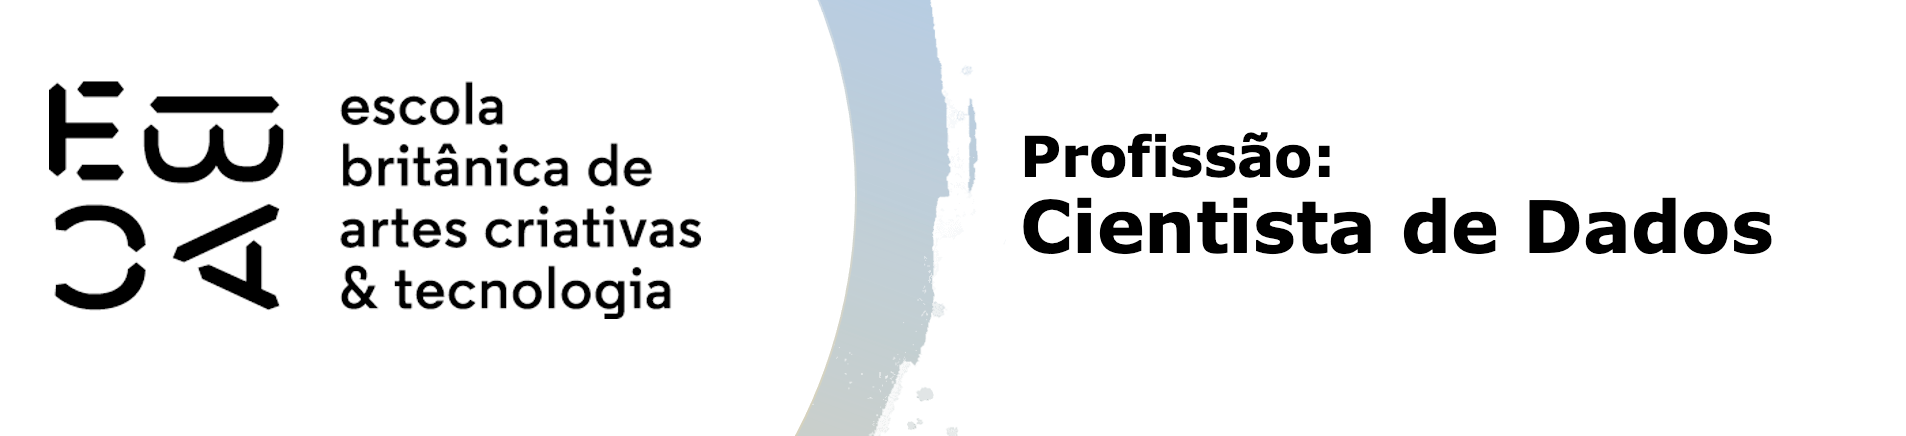

# Tarefa I

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from scipy.stats import t
from scipy.stats import ks_2samp

import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import metrics

df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [2]:
# Reescrevendo o código do módulo anterior

oot = df[pd.to_datetime(df.data_ref) > pd.to_datetime(df.data_ref.max()) - pd.DateOffset(months=3)]
train = df[pd.to_datetime(df.data_ref) <= pd.to_datetime(df.data_ref.max()) - pd.DateOffset(months=3)]

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

Número de análises por mês
Distribuição de registros por mês — Base de estudo


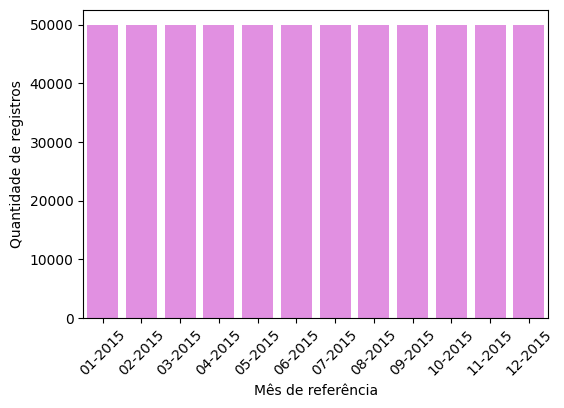

Distribuição de registros por mês — Base Out of Time (OOT)


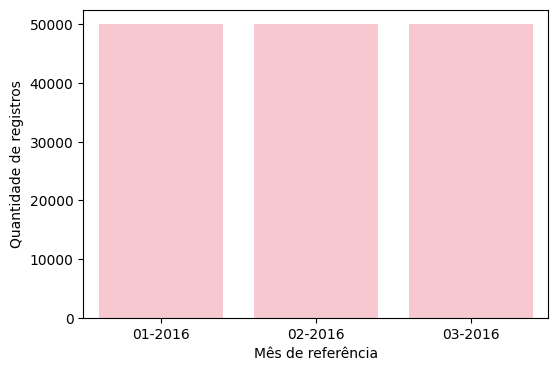

In [3]:
print("Número de análises por mês")

# Contagem real
train_counts = train["data_ref"].value_counts().sort_index()
oot_counts = oot["data_ref"].value_counts().sort_index()

print("Distribuição de registros por mês — Base de estudo")
fig1, ax = plt.subplots(figsize=(6, 4))
sns.barplot(x=train_counts.index.strftime('%m-%Y'), y=train_counts.values, color="violet", ax=ax)
ax.set_xlabel("Mês de referência")
ax.set_ylabel("Quantidade de registros")
plt.xticks(rotation=45)
plt.show()

print("Distribuição de registros por mês — Base Out of Time (OOT)")
fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(x=oot_counts.index.strftime('%m-%Y'), y=oot_counts.values, color="pink", ax=ax)
ax.set_xlabel("Mês de referência")
ax.set_ylabel("Quantidade de registros")
plt.show(fig)

In [4]:
df_ = train.drop(["index", "data_ref"], axis = 1)

des_uni = pd.DataFrame({
    "variavel": df_.columns,
    "dtype": df_.dtypes.astype(str),
    "nmissing": df_.isna().sum().values,
    "valores_unicos": df_.nunique().values
})

des_uni["tipo_var"] = des_uni["dtype"].apply(lambda x: "quantitativo" if any(t in x for t in ["float", "int"]) else "qualitativo")
des_uni["papel"] = des_uni["variavel"].apply(lambda x: "resposta" if x == "mau" else "covariavel")
des_uni["moda"] = des_uni["variavel"].apply(lambda v: df[v].mode().iloc[0] if not df[v].mode().empty else None)
des_uni["menos_comum"] = des_uni["variavel"].apply(lambda v: df[v].value_counts().idxmin() if df[v].nunique() > 0 else None)
des_uni["mínimo"] = des_uni["variavel"].apply(lambda v: round(df[v].min(), 2) if des_uni.loc[des_uni["variavel"] == v, "tipo_var"].item() == "quantitativo" else "-")
des_uni["máximo"] = des_uni["variavel"].apply(lambda v: round(df[v].max(), 2) if des_uni.loc[des_uni["variavel"] == v, "tipo_var"].item() == "quantitativo" else "-")
des_uni["média"] = des_uni["variavel"].apply(lambda v: round(df[v].mean(), 2) if des_uni.loc[des_uni["variavel"] == v, "tipo_var"].item() == "quantitativo" else "-")
des_uni = des_uni.drop(["variavel"], axis = 1)

des_uni

,dtype,nmissing,valores_unicos,tipo_var,papel,moda,menos_comum,mínimo,máximo,média
sexo,object,0,2,qualitativo,covariavel,F,M,-,-,-
posse_de_veiculo,object,0,2,qualitativo,covariavel,N,S,-,-,-
posse_de_imovel,object,0,2,qualitativo,covariavel,S,N,-,-,-
qtd_filhos,int64,0,8,quantitativo,covariavel,0,14,0,14,0.43
tipo_renda,object,0,5,qualitativo,covariavel,Assalariado,Bolsista,-,-,-
educacao,object,0,5,qualitativo,covariavel,Médio,Pós graduação,-,-,-
estado_civil,object,0,5,qualitativo,covariavel,Casado,Viúvo,-,-,-
tipo_residencia,object,0,6,qualitativo,covariavel,Casa,Comunitário,-,-,-
idade,int64,0,47,quantitativo,covariavel,40,22,22,68,43.8
tempo_emprego,float64,100875,3004,quantitativo,covariavel,4.216438,25.189041,0.12,42.91,7.75


A primeira observação notada é que há missing valores apenas entre os dados de tempo_emprego.
Notamos que há uma grande variabilidade entre os dados coletados de tempo_emprego e renda. E uma grande quantidade, se destacando em relação às outras, de respostas únicas para essas mesmas variáveis.

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

In [5]:
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['ep'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['woe'].sum(), tab['iv_parcial'].sum()

In [6]:
for var in des_uni[des_uni.papel=="covariavel"].index:
    if  (des_uni.loc[var, "valores_unicos"]>15):
       woe, iv_total = IV(pd.qcut(df[var],q = 10,duplicates='drop'), df.mau)
    else: 
       woe, iv_total  = IV(df[var], df["mau"])
        
    des_uni.loc[var, "woe"] = woe
    des_uni.loc[var, "IV"] = iv_total

des_uni.loc["bom", "dtype"] = "bool"
des_uni.loc["bom", "tipo_var"] = "qualitativo"
des_uni.loc["bom", "papel"] = "resposta"

des_uni

,dtype,nmissing,valores_unicos,tipo_var,papel,moda,menos_comum,mínimo,máximo,média,woe,IV
sexo,object,0.0,2.0,qualitativo,covariavel,F,M,-,-,-,0.036541,0.002185
posse_de_veiculo,object,0.0,2.0,qualitativo,covariavel,N,S,-,-,-,0.004822,0.000108
posse_de_imovel,object,0.0,2.0,qualitativo,covariavel,S,N,-,-,-,-0.062887,0.009693
qtd_filhos,int64,0.0,8.0,quantitativo,covariavel,0,14,0,14,0.43,-2.254980,0.001631
tipo_renda,object,0.0,5.0,qualitativo,covariavel,Assalariado,Bolsista,-,-,-,0.916414,0.009360
educacao,object,0.0,5.0,qualitativo,covariavel,Médio,Pós graduação,-,-,-,-0.093313,0.003547
estado_civil,object,0.0,5.0,qualitativo,covariavel,Casado,Viúvo,-,-,-,-0.098782,0.001126
tipo_residencia,object,0.0,6.0,qualitativo,covariavel,Casa,Comunitário,-,-,-,-0.296875,0.003045
idade,int64,0.0,47.0,quantitativo,covariavel,40,22,22,68,43.8,0.163894,0.020753
tempo_emprego,float64,100875.0,3004.0,quantitativo,covariavel,4.216438,25.189041,0.12,42.91,7.75,1.951134,0.386801


Sabemos que variáveis com IV inferior a 0,02 possuem poder preditivo praticamente nulo. Portanto, elas serão desconsideradas nas próximas etapas da análise. São elas:
* sexo
* posse_de_veiculo
* posse_de_imovel
* qtd_filhos
* tipo_renda
* educacao
* estad_civil
* tipo_residencia 

Além disso, observa-se que a variável qt_pessoas_residencia apresentou IV = inf, o que indica separação perfeita entre as classes — ou seja, há categorias que ocorrem exclusivamente em um dos grupos (“bom” ou “mau”). Esse comportamento pode sinalizar problemas de representatividade ou inconsistência nos dados, e por isso a variável deve ser reavaliada, possivelmente por meio de reagrupamento de categorias ou tratamento de outliers.<br>
Observa-se, também, que a variável renda apresenta um IV muito elevado, o que pode indicar risco de sobreajuste (overfitting) ou forte correlação com a variável resposta.<br>
Contudo, considerando que o estudo tem como objetivo analisar a inadimplência de indivíduos, faz sentido manter a variável para avaliação, visto que ela é conceitualmente relevante para o contexto da análise.

In [7]:
des_uni = des_uni.loc[des_uni.index.isin(["idade", "tempo_emprego", "renda", "qt_pessoas_residencia", "mau", "bom"])]

In [8]:
def biv_continua(var, df, ncat=None, bins=None, labels=None):
    df_local = df.copy()
    df_local['bom'] = 1 - df_local['mau']

    # Criar categoria
    if bins is not None:
        df_local['categoria'] = pd.cut(df_local[var], bins=bins, labels=labels, include_lowest=True)
    elif ncat is not None:
        df_local['categoria'], bins = pd.qcut(df_local[var], ncat, retbins=True, precision=0, duplicates='drop')
    else:
        raise ValueError("Você deve fornecer ncat ou bins.")

    g = df_local.groupby('categoria')

    biv = pd.DataFrame({
        'qt_bom': g['bom'].sum(),
        'qt_mau': g['mau'].sum(),
        'mau': g['mau'].mean(), 
        var: g[var].mean(), 
        'cont': g[var].count()
    })

    # Intervalos de confiança para mau
    biv['ep'] = (biv['mau'] * (1 - biv['mau']) / biv['cont']) ** 0.5
    biv['mau_sup'] = biv['mau'] + t.ppf(0.975, biv['cont'] - 1) * biv['ep']
    biv['mau_inf'] = biv['mau'] - t.ppf(0.975, biv['cont'] - 1) * biv['ep']

    tx_mau_geral = df_local['mau'].mean()
    woe_geral = np.log(tx_mau_geral / (1 - tx_mau_geral))

    # WOE e IV
    biv['logit'] = np.log(biv['mau'] / (1 - biv['mau']))
    biv['woe'] = biv['logit'] - woe_geral
    biv['iv_parcial'] = ((biv['qt_mau'] / df_local['mau'].sum()) -
                         (biv['qt_bom'] / df_local['bom'].sum())) * biv['woe']
    biv['IV_total'] = biv['iv_parcial'].sum()

    print(f"\n🔹 Variável: {var}")
    print(f"📊 IV total: {biv['IV_total'].iloc[0]:.5f}\n")
    print(biv[[var, 'qt_mau', 'qt_bom', 'mau', 'woe', 'iv_parcial']].to_string(index=False))

    # Gráficos
    fig, ax = plt.subplots(2, 1, figsize=(10, 6))
    ax[0].plot(biv[var], biv['woe'], ':bo', label='WOE')
    ax[0].set_ylabel("Weight of Evidence")
    ax[0].set_title(f"WOE de {var}")
    ax[0].legend()
    biv['cont'].plot.bar(ax=ax[1])
    ax[1].set_title("Frequência por categoria")
    plt.tight_layout()
    plt.show()

    return biv


C:\Users\marin\AppData\Local\Temp\ipykernel_30116\2232642561.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df_local.groupby('categoria')



🔹 Variável: idade
📊 IV total: 0.02210

    idade  qt_mau  qt_bom      mau       woe   iv_parcial
26.637717    4376   48406 0.082907  0.329202 1.102773e-02
29.542461    2205   28835 0.071037  0.161829 1.454996e-03
32.030577    3430   47883 0.066845  0.096491 8.307896e-04
34.479059    2138   31146 0.064235  0.053876 1.648779e-04
36.547225    2171   32736 0.062194  0.019404 2.209162e-05
39.042658    3394   52117 0.061141  0.001209 1.353246e-07
41.496932    1989   32726 0.057295 -0.067847 2.585342e-04
43.467599    1751   30933 0.053574 -0.138945 9.897019e-04
45.997475    2730   44797 0.057441 -0.065148 3.267408e-04
48.443340    1360   25908 0.049875 -0.214376 1.902316e-03
50.934933    2163   41392 0.049661 -0.218900 3.161978e-03
53.945141    2089   37048 0.053377 -0.142838 1.250315e-03
57.028147    2182   35548 0.057832 -0.057951 2.058869e-04
60.353009    2674   44339 0.056878 -0.075598 4.332225e-04
64.526701    1991   29543 0.063138  0.035481 6.720440e-05


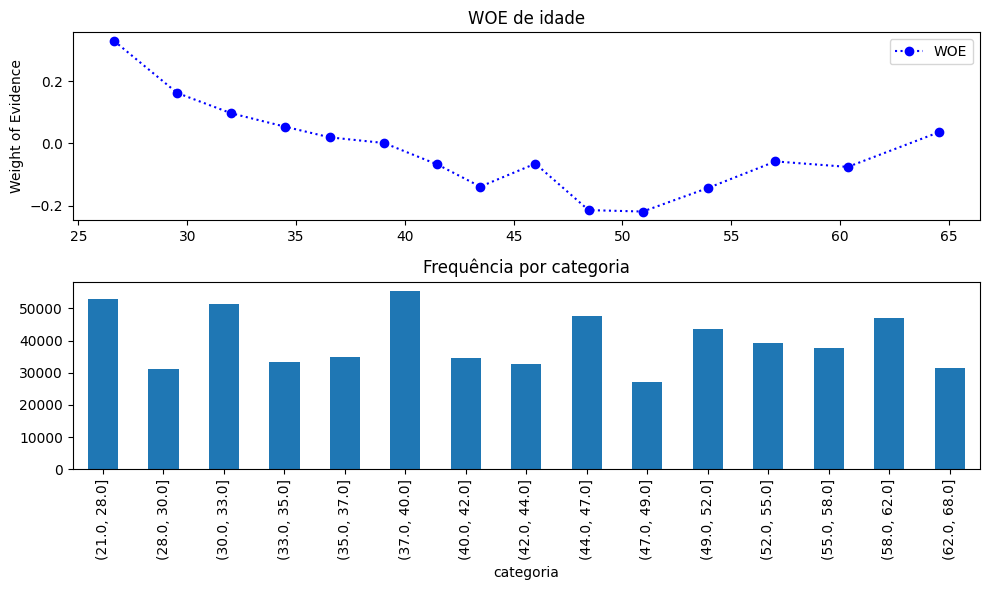

C:\Users\marin\AppData\Local\Temp\ipykernel_30116\2232642561.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df_local.groupby('categoria')



🔹 Variável: tempo_emprego
📊 IV total: 0.33041

 tempo_emprego  qt_mau  qt_bom      mau       woe  iv_parcial
      0.546043    3714   29614 0.111438  0.656553    0.032033
      1.232753    3438   30051 0.102661  0.564685    0.022859
      1.963814    3128   29939 0.094596  0.473923    0.015270
      2.832155    2873   30843 0.085212  0.359138    0.008496
      3.648448    2695   30440 0.081334  0.308332    0.006017
      4.369197    2519   30598 0.076064  0.235618    0.003400
      5.132058    2311   30818 0.069758  0.142273    0.001190
      6.055297    1978   31356 0.059339 -0.030628    0.000051
      6.957728    1735   31520 0.052173 -0.166924    0.001436
      7.987581    1583   31699 0.047563 -0.264272    0.003453
      9.124723    1447   31779 0.043550 -0.356622    0.006034
     10.686020    1245   32399 0.037005 -0.526301    0.012386
     13.148602     789   32090 0.023997 -0.972842    0.034468
     16.838299     479   33294 0.014183 -1.508741    0.069443
     25.921092     231

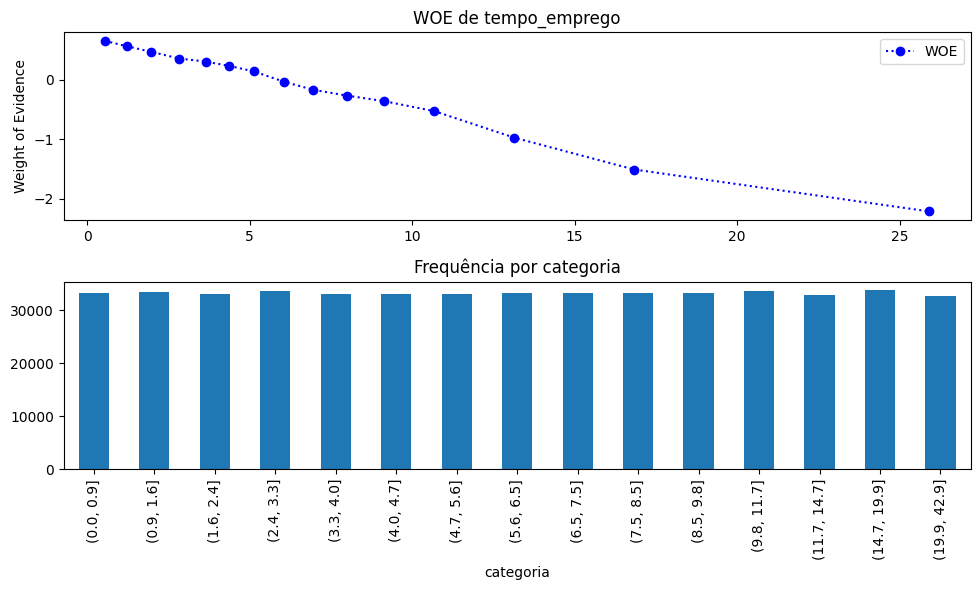

C:\Users\marin\AppData\Local\Temp\ipykernel_30116\2232642561.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df_local.groupby('categoria')



🔹 Variável: qt_pessoas_residencia
📊 IV total: 0.00126

 qt_pessoas_residencia  qt_mau  qt_bom      mau       woe  iv_parcial
              1.750121   26050  408788 0.059907 -0.020488    0.000301
              3.000000    6803   97323 0.065334  0.072019    0.000929
              4.159447    3790   57246 0.062095  0.017699    0.000032


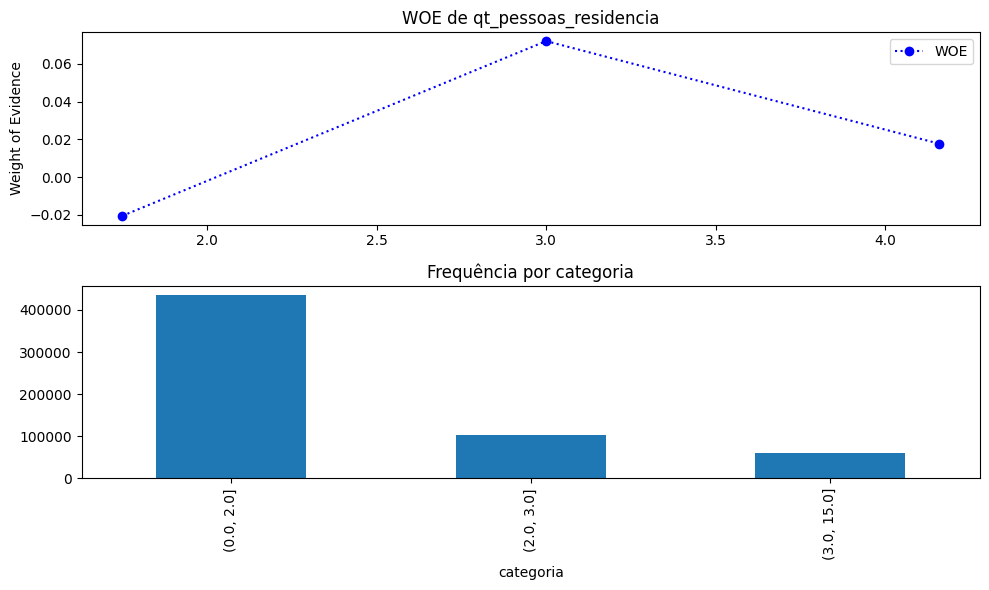

C:\Users\marin\AppData\Local\Temp\ipykernel_30116\2232642561.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df_local.groupby('categoria')



🔹 Variável: renda
📊 IV total: 1.09797

        renda  qt_mau  qt_bom      mau       woe  iv_parcial
  1176.929450    8066   21934 0.268867  1.732311    0.313876
  2077.711359    4995   25005 0.166500  1.122053    0.103150
  2810.963431    3743   26258 0.124763  0.784608    0.043575
  3533.767329    2995   27007 0.099827  0.533539    0.018031
  4282.345853    2580   27419 0.086003  0.369244    0.008027
  5082.267761    2200   27808 0.073314  0.195825    0.002091
  5953.257972    1896   28096 0.063217  0.036810    0.000069
  6915.681076    1637   28362 0.054568 -0.119494    0.000678
  7994.048992    1433   28567 0.047767 -0.259791    0.003014
  9215.231775    1331   28669 0.044367 -0.337195    0.004912
 10633.834211    1119   28883 0.037298 -0.518127    0.010742
 12262.822292     984   29018 0.032798 -0.651355    0.016059
 14204.316589     837   29159 0.027904 -0.818004    0.023654
 16633.129084     733   29269 0.024432 -0.954447    0.030495
 19774.878134     636   29361 0.021202 -1.099

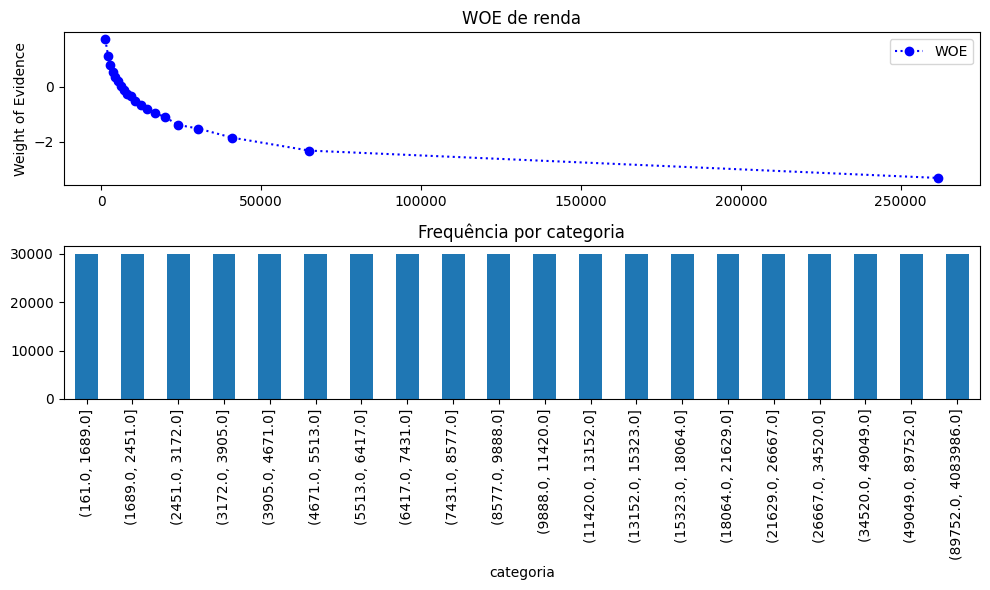

In [9]:
quant_vars = des_uni[(des_uni['papel'] == "covariavel") & (des_uni['tipo_var'] == "quantitativo")].index

for var in quant_vars:
    if (des_uni.loc[var, "valores_unicos"] > 16) & (des_uni.loc[var, "valores_unicos"] < 10001):
        gr = 15
    elif (des_uni.loc[var, "valores_unicos"] > 10000):
        gr = 20
    else:
        gr = des_uni.loc[var, "valores_unicos"]
    gr = int(gr)
    gr = max(gr, 0)  # Ensure non-negative
    biv_continua(var, df_, ncat = gr)

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [10]:
#Substituirei os valores em branco (null) pela média por tipo de renda

train["tempo_emprego"] = train["tempo_emprego"].fillna(train.groupby(["tipo_renda"])["tempo_emprego"].transform("mean"))
oot["tempo_emprego"] = oot["tempo_emprego"].fillna(oot.groupby(["tipo_renda"])["tempo_emprego"].transform("mean"))

C:\Users\marin\AppData\Local\Temp\ipykernel_30116\3169470185.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["tempo_emprego"] = train["tempo_emprego"].fillna(train.groupby(["tipo_renda"])["tempo_emprego"].transform("mean"))
C:\Users\marin\AppData\Local\Temp\ipykernel_30116\3169470185.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oot["tempo_emprego"] = oot["tempo_emprego"].fillna(oot.groupby(["tipo_renda"])["tempo_emprego"].transform("mean"))


Por proximidade do valor de woe agruparemos: 
* idade de 30 a 35, 35 a 40, 47 a 52 e 55 a 62
* tempo_emprego 0 a 1.9 e 2,9 a 5,8
  
E os outliers de renda 10793 a 18318, 18318 a 29748 e 29748 a 4083986

C:\Users\marin\AppData\Local\Temp\ipykernel_30116\2232642561.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df_local.groupby('categoria')



🔹 Variável: idade
📊 IV total: 0.01644

    idade  qt_mau  qt_bom      mau       woe  iv_parcial
27.691740    4329   51653 0.077328  0.253479    0.006705
32.496929    6793   94642 0.066969  0.098482    0.001712
38.079265    5565   84853 0.061547  0.008268    0.000010
43.437269    5579   93822 0.056126 -0.089699    0.001282
49.440624    4414   81934 0.051119 -0.188442    0.004707
53.549708    1513   26953 0.053151 -0.147309    0.000965
58.439569    5432   89982 0.056931 -0.074611    0.000857
63.840093    1522   21804 0.065249  0.070623    0.000200


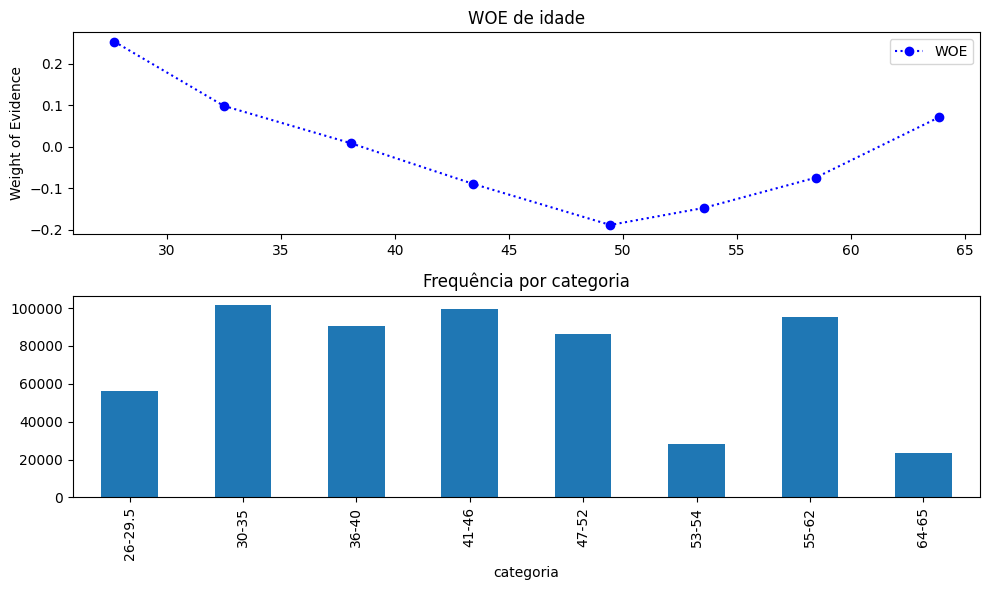

,qt_bom,qt_mau,mau,idade,cont,ep,mau_sup,mau_inf,logit,woe,iv_parcial,IV_total
categoria,,,,,,,,,,,,
26-29.5,51653,4329,0.077328,27.691740,55982,0.001129,0.079541,0.075116,-2.479212,0.253479,0.006705,0.016439
30-35,94642,6793,0.066969,32.496929,101435,0.000785,0.068507,0.065431,-2.634209,0.098482,0.001712,0.016439
36-40,84853,5565,0.061547,38.079265,90418,0.000799,0.063114,0.059981,-2.724423,0.008268,0.000010,0.016439
41-46,93822,5579,0.056126,43.437269,99401,0.000730,0.057557,0.054695,-2.822390,-0.089699,0.001282,0.016439
47-52,81934,4414,0.051119,49.440624,86348,0.000749,0.052588,0.049650,-2.921133,-0.188442,0.004707,0.016439
53-54,26953,1513,0.053151,53.549708,28466,0.001330,0.055757,0.050545,-2.880000,-0.147309,0.000965,0.016439
55-62,89982,5432,0.056931,58.439569,95414,0.000750,0.058401,0.055461,-2.807302,-0.074611,0.000857,0.016439
64-65,21804,1522,0.065249,63.840093,23326,0.001617,0.068419,0.062080,-2.662068,0.070623,0.000200,0.016439


In [11]:
bins = [26, 29.5, 35, 40, 46, 52, 54, 62, 65]
labels = [
    "26-29.5",
    "30-35",
    "36-40",
    "41-46",
    "47-52",
    "53-54",
    "55-62",
    "64-65"
]

biv_continua("idade", df = df_, bins = bins, labels = labels)

C:\Users\marin\AppData\Local\Temp\ipykernel_30116\2232642561.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df_local.groupby('categoria')



🔹 Variável: tempo_emprego
📊 IV total: 0.22614

 tempo_emprego  qt_mau  qt_bom      mau       woe  iv_parcial
      1.038566    8548   72206 0.105852  0.598865    0.062945
      3.858838   12681  148119 0.078862  0.274780    0.022847
      6.430176    2477   41402 0.056451 -0.083590    0.000493
      8.183445    3393   69530 0.046529 -0.287353    0.008858
     14.464200    3003  122072 0.024010 -0.972308    0.131003


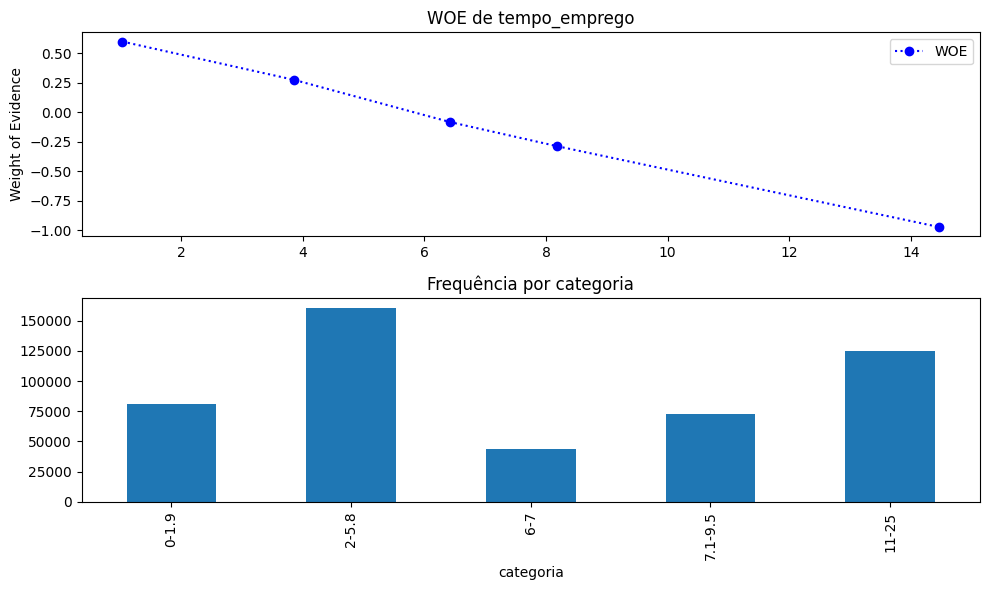

,qt_bom,qt_mau,mau,tempo_emprego,cont,ep,mau_sup,mau_inf,logit,woe,iv_parcial,IV_total
categoria,,,,,,,,,,,,
0-1.9,72206,8548,0.105852,1.038566,80754,0.001083,0.107974,0.103730,-2.133826,0.598865,0.062945,0.226145
2-5.8,148119,12681,0.078862,3.858838,160800,0.000672,0.080179,0.077545,-2.457911,0.274780,0.022847,0.226145
6-7,41402,2477,0.056451,6.430176,43879,0.001102,0.058610,0.054291,-2.816281,-0.083590,0.000493,0.226145
7.1-9.5,69530,3393,0.046529,8.183445,72923,0.000780,0.048057,0.045000,-3.020044,-0.287353,0.008858,0.226145
11-25,122072,3003,0.024010,14.464200,125075,0.000433,0.024858,0.023161,-3.704999,-0.972308,0.131003,0.226145


In [12]:
bins_te = [0, 1.9, 5.8, 7.0, 9.5, 25]
labels_te = [
    "0-1.9",
    "2-5.8",
    "6-7",
    "7.1-9.5",
    "11-25"
]
biv_continua("tempo_emprego", df = df_, bins = bins_te, labels = labels_te)

C:\Users\marin\AppData\Local\Temp\ipykernel_30116\2232642561.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df_local.groupby('categoria')



🔹 Variável: renda
📊 IV total: 1.06860

        renda  qt_mau  qt_bom      mau       woe  iv_parcial
   863.736135    4523    9412 0.324578  1.999881    0.213442
  1483.217994    4009   14377 0.218046  1.455603    0.122106
  2025.951398    3603   17620 0.169769  1.145423    0.076801
  2577.355822    3140   20398 0.133401  0.861477    0.042629
  3168.251863    2808   22577 0.110617  0.648232    0.023696
  3803.644550    2540   24614 0.093541  0.461540    0.011827
  4512.365960    2407   26210 0.084111  0.344931    0.006610
  5316.825491    2119   27976 0.070410  0.152288    0.001244
  6229.539847    1873   29426 0.059842 -0.021646    0.000024
  7283.788727    1656   30305 0.051813 -0.174217    0.001498
  8508.836845    1555   31464 0.047094 -0.274677    0.003685
  9968.267468    1361   32302 0.040430 -0.434218    0.008770
 14088.439322    3023  101142 0.029021 -0.777585    0.075454
 23199.613387    1261   69875 0.017727 -1.282112    0.114903
108507.438516     765  105657 0.007188 -2.195

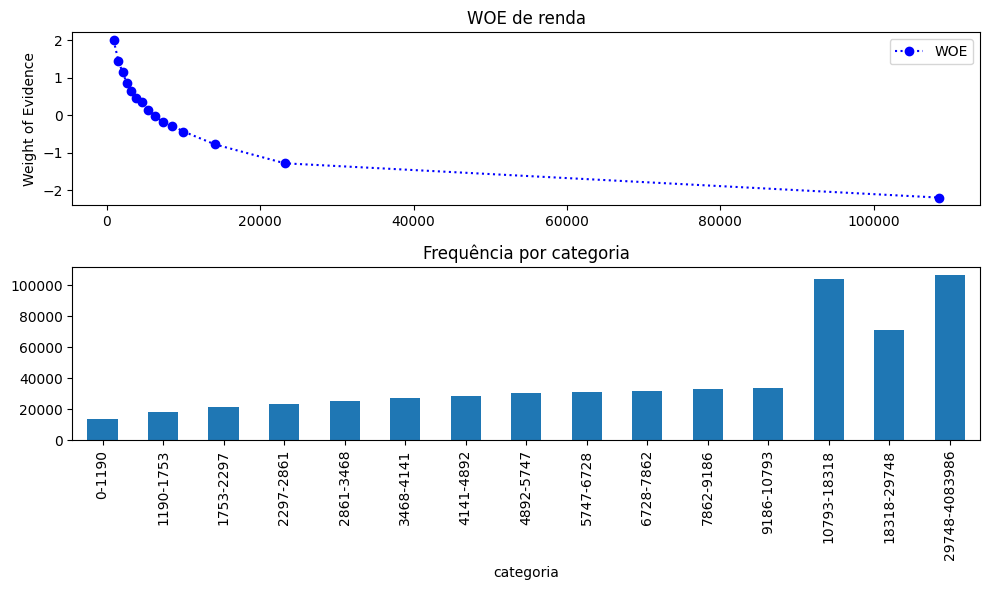

,qt_bom,qt_mau,mau,renda,cont,ep,mau_sup,mau_inf,logit,woe,iv_parcial,IV_total
categoria,,,,,,,,,,,,
0-1190,9412,4523,0.324578,863.736135,13935,0.003966,0.332353,0.316804,-0.732810,1.999881,0.213442,1.068598
1190-1753,14377,4009,0.218046,1483.217994,18386,0.003045,0.224015,0.212077,-1.277088,1.455603,0.122106,1.068598
1753-2297,17620,3603,0.169769,2025.951398,21223,0.002577,0.174820,0.164717,-1.587268,1.145423,0.076801,1.068598
2297-2861,20398,3140,0.133401,2577.355822,23538,0.002216,0.137745,0.129057,-1.871214,0.861477,0.042629,1.068598
2861-3468,22577,2808,0.110617,3168.251863,25385,0.001969,0.114475,0.106758,-2.084459,0.648232,0.023696,1.068598
3468-4141,24614,2540,0.093541,3803.644550,27154,0.001767,0.097004,0.090077,-2.271151,0.461540,0.011827,1.068598
4141-4892,26210,2407,0.084111,4512.365960,28617,0.001641,0.087327,0.080895,-2.387760,0.344931,0.006610,1.068598
4892-5747,27976,2119,0.070410,5316.825491,30095,0.001475,0.073301,0.067520,-2.580403,0.152288,0.001244,1.068598
5747-6728,29426,1873,0.059842,6229.539847,31299,0.001341,0.062470,0.057214,-2.754337,-0.021646,0.000024,1.068598


In [13]:
bins_renda = [
    0,     
    1190,
    1753, 
    2297,
    2861, 
    3468, 
    4141, 
    4892, 
    5747, 
    6728, 
    7862, 
    9186, 
    10793,    
    18318,    
    29748,    
    4083986   
]

labels_renda = [
    "0-1190", 
    "1190-1753", 
    "1753-2297", 
    "2297-2861", 
    "2861-3468", 
    "3468-4141", 
    "4141-4892", 
    "4892-5747", 
    "5747-6728",
    "6728-7862",
    "7862-9186",
    "9186-10793",
    "10793-18318",
    "18318-29748",
    "29748-4083986"
]


biv_continua("renda", df = df_, bins = bins_renda, labels = labels_renda)

In [14]:
# Já considerando minha resposta anterior
formula = '''
    mau ~ I(idade**2) + I(-tempo_emprego) + I(1/renda) 
'''

rl = smf.glm(formula, data=df_, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     ['mau[False]', 'mau[True]']   No. Observations:               499125
Model:                                     GLM   Df Residuals:                   499121
Model Family:                         Binomial   Df Model:                            3
Link Function:                           Logit   Scale:                          1.0000
Method:                                   IRLS   Log-Likelihood:            -1.0217e+05
Date:                         Sat, 18 Oct 2025   Deviance:                   2.0435e+05
Time:                                 15:39:44   Pearson chi2:                 4.84e+05
No. Iterations:                              7   Pseudo R-squ. (CS):            0.04583
Covariance Type:                     nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             2.7822      0.017    159.288      0.000       2.748       2.816
I(idade ** 2)      2.421e-05    8.2e-06      2.954      0.003    8.15e-06    4.03e-05
I(-tempo_emprego)    -0.0711      0.002    -46.374      0.000      -0.074      -0.068
I(1 / renda)      -1996.4991     17.703   -112.780      0.000   -2031.195   -1961.803
=====================================================================================
"""

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [15]:
oot['score'] = rl.predict(oot)

# Acurácia
acc = metrics.accuracy_score(oot.mau, oot.score>.068)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(oot.mau, oot.score)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(oot.loc[oot.mau == 1, 'score'], oot.loc[oot.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))

Acurácia: 14.5% 
AUC: 26.8% 
GINI: -46.3%
KS: 33.6%


C:\Users\marin\AppData\Local\Temp\ipykernel_30116\2536349016.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oot['score'] = rl.predict(oot)


Apesar da consistência estatística, as métricas de desempenho preditivo indicam baixa capacidade discriminatória. O modelo final apresentou acurácia de 14,5%, AUC de 26,7% e índice de Gini negativo (-46,6%), sugerindo que o modelo está classificando de forma inversa em relação à realidade observada. O KS (Kolmogorov–Smirnov) de 33,8% demonstra alguma separação entre bons e maus pagadores, porém ainda insuficiente para caracterizar um bom poder preditivo.

Esses resultados indicam que, embora o modelo esteja estatisticamente ajustado e teoricamente coerente, sua performance preditiva é insatisfatória, demandando ajustes adicionais — como revisão de variáveis explicativas, novos tratamentos de outliers ou o uso de técnicas não lineares mais robustas (como árvores de decisão ou modelos de ensemble) para capturar padrões mais complexos nos dados.

# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento 

## Pré processamento

In [16]:
# Importanto a biblioteca
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# E importanto novamente a base de dados
df = pd.read_feather('credit_scoring.ftr')
X, y = df.drop(["data_ref", "index", "mau"], axis = 1), df["mau"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

Pelo o que observamos no exercício anterior há apenas valores números entre os dados numéricos de tempo_emprego. Substituido anteriormente pela média agrupada pelo tipo de renda.

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

In [18]:
limpeza = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  
    ('scaler', StandardScaler())
])

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

Para identificação de outliers lançou-se mão de observações dos números de extremos e do gráfico. Para substituílos utilizei o agrupamento dos dados de outlier com os dados mais próximos a ele.

In [19]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import SVC

In [20]:
outliers = Pipeline([
    ('detectar', IsolationForest(contamination=0.1, random_state=0)),
    ('clf', SVC())
])

### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

A seleção de variáveis foi feita pelo método de filtro, utilizando o Information Value (IV) da análise bivariada como critério de decisão.

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin

In [22]:
class IVSelector(BaseEstimator, TransformerMixin):
    """
    Seletor de features por IV (método de filtro).
    - iv_threshold: Mínimo IV para reter feature (default: 0.02).
    - bins: Bins para contínuas.
    """
    def __init__(self, iv_threshold=0.02, bins=10):
        self.iv_threshold = iv_threshold
        self.bins = bins
        self.iv_scores_ = None
        self.selected_features_ = None

    def fit(self, X, y):
        # X deve ser DataFrame; y Series binária
        data = pd.concat([X, y], axis=1)
        iv_df, _ = iv_woe(data, y.name, self.bins)
        self.iv_scores_ = dict(zip(iv_df['Variable'], iv_df['IV']))
        self.selected_features_ = [col for col, iv in self.iv_scores_.items() if iv > self.iv_threshold]
        print(f"Features selecionadas (IV > {self.iv_threshold}): {self.selected_features_}")
        return self

    def transform(self, X):
        return X[self.selected_features_]

In [23]:
variaveis = Pipeline([
    ('iv_select', IVSelector(iv_threshold=0.3, bins=5)),
    ('classifier', LogisticRegression())
])

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [24]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

In [25]:
pca = make_pipeline(
    PCA(n_components=5),
    SVC()
)

### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [26]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression

In [27]:
num = df[['qtd_filhos',	
          'idade', 
          'tempo_emprego', 
          'qt_pessoas_residencia', 
          'renda']]

cat = df[['sexo',
        'posse_de_veiculo',
        'posse_de_imovel',
        'tipo_renda',
        'educacao',
        'estado_civil',
        'tipo_residencia']]

In [28]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat)
    ])

# Create the pipeline
dummies = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression())])

### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [29]:
pipe = Pipeline(steps=[('Substituição de nulos', limpeza),  
                        ('Remoção de outliers', outliers),
                        ('Seleção de variaveis', variaveis),
                        ('PCA', pca),
                        ('Criação de Dummies', dummies)
                    ]
                )

In [30]:
print(pipe.named_steps)

{'Substituição de nulos': Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())]), 'Remoção de outliers': Pipeline(steps=[('detectar',
                 IsolationForest(contamination=0.1, random_state=0)),
                ('clf', SVC())]), 'Seleção de variaveis': Pipeline(steps=[('iv_select', IVSelector(bins=5, iv_threshold=0.3)),
                ('classifier', LogisticRegression())]), 'PCA': Pipeline(steps=[('pca', PCA(n_components=5)), ('svc', SVC())]), 'Criação de Dummies': Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                          qtd_filhos  idade  tempo_emprego  qt_pessoas_residencia     renda
0                0     43       6.873973                    1.0   2515.39
1                0     35       4.526027                    2.0   3180.19
2                2     31       0.243836                    4.0   1582.29
3          

# b - Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



Considerando as fases e estudos anteriores, continuaremos fazendo esse estudo:

In [31]:
import pandas as pd
import time 

df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [32]:
df.shape

(750000, 15)

Para análise do tempo de processamento do modelo utilizarei uma amostra de 5% da base de dados, 37500 linhas, comparando-a com a análise da base completa.

In [33]:
dt = df.sample(37500)
dt.drop(['data_ref','index'], axis=1, inplace=True)
data = dt.sample(frac=0.95, random_state=786)
data_unseen = dt.drop(data.index)

data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)

In [34]:
from pycaret.classification import *
from pycaret.utils.generic import check_metric

In [37]:
def model_pycaret(data, resposta, data_unseen=None):
    
    tm_inicio = time.time()
    
    print("\nAnálise inicial dos dados da base:")
    exp_clf101 = setup(data=data, target=resposta, session_id=123)
    
    print("Comparando os resultados dos modelos:")
    try:
        fold_input = input("\n📊 Quantos folds você deseja usar na validação cruzada? (pressione Enter para usar 10): ")
        fold_num = int(fold_input) if fold_input.strip() != "" else 10
    except ValueError:
        fold_num = 10
        print("⚠️ Valor inválido, usando padrão: 10 folds")
    
    compare_models(fold=fold_num, sort="AUC")
    results = pull()
    print("\nMétricas dos modelos apurados: ")
    display(results)

    print("\nModelos disponíveis:")
    print(results.index.to_list())
    
    model = input("\n👉 Digite o nome do modelo que deseja usar (ou pressione Enter para usar o melhor modelo automaticamente): ")
    if model.strip() == "":
        model = results.index[0]
        print(f"\n🔹 Nenhum modelo informado. Usando o melhor modelo: {model}")
    else:
        if model not in results.index:
            print(f"⚠️ Modelo '{model}' não encontrado. Usando o melhor modelo automaticamente: {results.index[0]}")
            model = results.index[0]
        else:
            print(f"\n🔹 Modelo escolhido manualmente: {model}")

    # Criando e desenvolvendo o modelo
    bm = create_model(model)
    tun = tune_model(bm, optimize='F1')
    
    # Diagnostic print (remove after testing)
    print(f"Model type: {type(tun)}")
    print(f"Has predict_proba? {hasattr(tun, 'predict_proba')}")

    # Visualização do modelo (com checks para plots que precisam de proba)
    if hasattr(tun, 'predict_proba'):
        plot_model(tun, plot='auc')
        plot_model(tun, plot='pr')
    else:
        print("⚠️ Skipping AUC and PR plots: Model does not support probability predictions.")
    
    plot_model(tun, plot='feature')  # Não precisa de proba
    plot_model(tun, plot='confusion_matrix')  # Não precisa de proba

    print("\nAvaliando o modelo:")
    evaluate_model(tun)
    predict_model(tun)
    print("\nResultado antes da finalização do modelo:")
    print(tun)
    
    final = finalize_model(tun)
    print("\nResultado do modelo finalizado:")
    print(final)
    
    print("\nDados do melhor modelo encontrado depois da modelagem: ", final)

    # Bloco pro data_unseen
    if data_unseen is not None:
        print("\nFazendo previsões no conjunto não utilizado ainda")
        unseen_predictions = predict_model(final, data=data_unseen)
        
        true_labels = unseen_predictions[resposta].astype(str)
        pred_labels = unseen_predictions['prediction_label'].astype(str)  # PyCaret 3.x naming
        
        acc = check_metric(true_labels, pred_labels, metric='Accuracy')
        print(f"\nAcurácia do modelo final ({resposta}): {acc}")
    else:
        print("\nNenhum dataset 'data_unseen' fornecido para teste.")
    
    tm_fim = time.time()
    print(f"\nTempo total de execução: {tm_fim - tm_inicio:.2f} segundos")
    
    return {"modelo final": final, "metricas": results}

Utilizando o sample da base de dados:

Análise inicial dos dados da base:


,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(37500, 13)"
4,Transformed data shape,"(37500, 30)"
5,Transformed train set shape,"(26250, 30)"
6,Transformed test set shape,"(11250, 30)"
7,Numeric features,5
8,Categorical features,7
9,Rows with missing values,16.7%


Comparando os resultados dos modelos:



📊 Quantos folds você deseja usar na validação cruzada? (pressione Enter para usar 10):  


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
svm,SVM - Linear Kernel,0.9044,0.7829,0.1408,0.3582,0.1362,0.1089,0.1352,0.0690
gbc,Gradient Boosting Classifier,0.9217,0.7792,0.0381,0.4694,0.0703,0.0593,0.1158,0.4200
ada,Ada Boost Classifier,0.9216,0.7776,0.0313,0.4817,0.0572,0.0481,0.0975,0.1710
lr,Logistic Regression,0.9221,0.7738,0.0000,0.0000,0.0000,0.0000,0.0000,0.7940
lightgbm,Light Gradient Boosting Machine,0.9219,0.7656,0.0474,0.4919,0.0861,0.0734,0.1333,0.3150
catboost,CatBoost Classifier,0.9209,0.7655,0.0601,0.4537,0.1059,0.0890,0.1424,3.8960
xgboost,Extreme Gradient Boosting,0.9198,0.7483,0.0621,0.4063,0.1074,0.0885,0.1339,0.1530
rf,Random Forest Classifier,0.9040,0.7076,0.0900,0.2175,0.1271,0.0856,0.0951,0.2790
nb,Naive Bayes,0.6069,0.6849,0.6826,0.1264,0.2129,0.0940,0.1545,0.0590
qda,Quadratic Discriminant Analysis,0.1639,0.6538,0.9887,0.0845,0.1557,0.0142,0.0776,0.0640



Métricas dos modelos apurados: 


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
svm,SVM - Linear Kernel,0.9044,0.7829,0.1408,0.3582,0.1362,0.1089,0.1352,0.069
gbc,Gradient Boosting Classifier,0.9217,0.7792,0.0381,0.4694,0.0703,0.0593,0.1158,0.420
ada,Ada Boost Classifier,0.9216,0.7776,0.0313,0.4817,0.0572,0.0481,0.0975,0.171
lr,Logistic Regression,0.9221,0.7738,0.0000,0.0000,0.0000,0.0000,0.0000,0.794
lightgbm,Light Gradient Boosting Machine,0.9219,0.7656,0.0474,0.4919,0.0861,0.0734,0.1333,0.315
catboost,CatBoost Classifier,0.9209,0.7655,0.0601,0.4537,0.1059,0.0890,0.1424,3.896
xgboost,Extreme Gradient Boosting,0.9198,0.7483,0.0621,0.4063,0.1074,0.0885,0.1339,0.153
rf,Random Forest Classifier,0.9040,0.7076,0.0900,0.2175,0.1271,0.0856,0.0951,0.279
nb,Naive Bayes,0.6069,0.6849,0.6826,0.1264,0.2129,0.0940,0.1545,0.059
qda,Quadratic Discriminant Analysis,0.1639,0.6538,0.9887,0.0845,0.1557,0.0142,0.0776,0.064



Modelos disponíveis:
['svm', 'gbc', 'ada', 'lr', 'lightgbm', 'catboost', 'xgboost', 'rf', 'nb', 'qda', 'knn', 'ridge', 'lda', 'et', 'dt', 'dummy']



👉 Digite o nome do modelo que deseja usar (ou pressione Enter para usar o melhor modelo automaticamente):  



🔹 Nenhum modelo informado. Usando o melhor modelo: svm


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9223,0.7880,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.9223,0.7915,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.9238,0.7721,0.0686,0.5833,0.1228,0.1082,0.1814
3,0.8838,0.7606,0.3676,0.2988,0.3297,0.2668,0.2685
4,0.9173,0.7798,0.1765,0.4235,0.2491,0.2132,0.2363
5,0.9223,0.7780,0.0049,1.0000,0.0097,0.0090,0.0671
6,0.9211,0.8101,0.0049,0.2500,0.0096,0.0066,0.0250
7,0.8895,0.7937,0.2732,0.2843,0.2786,0.2188,0.2189
8,0.8190,0.7683,0.4732,0.2091,0.2900,0.2037,0.2262


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9025,0.7884,0.2745,0.3415,0.3043,0.2526,0.2543
1,0.8533,0.7863,0.4314,0.2465,0.3137,0.2384,0.2501
2,0.8762,0.7673,0.3186,0.2590,0.2857,0.2187,0.2201
3,0.9223,0.7648,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.8690,0.7797,0.3824,0.2635,0.3120,0.2423,0.2474
5,0.8522,0.7742,0.4439,0.2493,0.3193,0.2437,0.2564
6,0.8632,0.8090,0.4683,0.2775,0.3485,0.2776,0.2895
7,0.8922,0.7940,0.2585,0.2880,0.2725,0.2145,0.2148
8,0.7916,0.7696,0.5512,0.1989,0.2924,0.2006,0.2367


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Model type: <class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'>
Has predict_proba? False
⚠️ Skipping AUC and PR plots: Model does not support probability predictions.


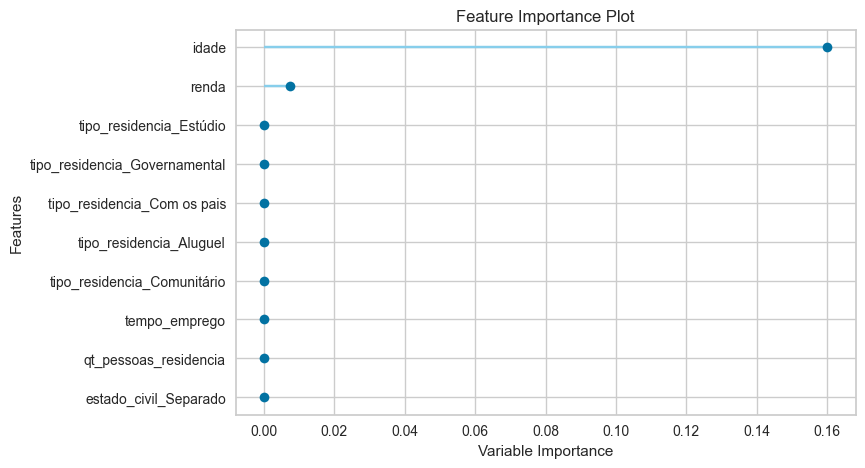

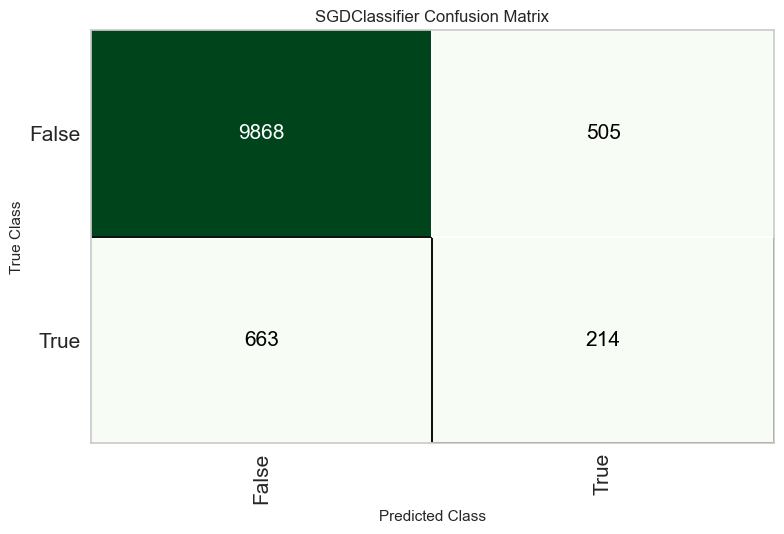


Avaliando o modelo:


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,SVM - Linear Kernel,0.8962,0.5977,0.2440,0.2976,0.2682,0.2129,0.2141



Resultado antes da finalização do modelo:
SGDClassifier(alpha=0.05, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.001, fit_intercept=True,
              l1_ratio=0.3900000001, learning_rate='adaptive', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l1',
              power_t=0.5, random_state=123, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

Resultado do modelo finalizado:
Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['qtd_filhos', 'idade',
                                             'tempo_emprego',
                                             'qt_pessoas_residencia', 'renda'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
 

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,SVM - Linear Kernel,0.8123,0.6750,0.5149,0.1938,0.2816,0.1984,0.2299



Acurácia do modelo final (mau): 0.0

Tempo total de execução: 109.08 segundos


{'modelo final': Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWra...
                  SGDClassifier(alpha=0.05, average=False, class_weigh

In [38]:
print("Utilizando o sample da base de dados:")
model_pycaret(dt, 'mau', data_unseen)

In [39]:
df.drop(['data_ref','index'], axis=1, inplace=True)
data_df = df.sample(frac=0.95, random_state=786)
data_test = df.drop(data_df.index)

Utilizando a base de dados completa:

Análise inicial dos dados da base:


,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(750000, 13)"
4,Transformed data shape,"(750000, 30)"
5,Transformed train set shape,"(525000, 30)"
6,Transformed test set shape,"(225000, 30)"
7,Numeric features,5
8,Categorical features,7
9,Rows with missing values,16.8%


Comparando os resultados dos modelos:



📊 Quantos folds você deseja usar na validação cruzada? (pressione Enter para usar 10):  


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.9222,0.7811,0.0241,0.5505,0.0462,0.0399,0.1031,13.9840
lightgbm,Light Gradient Boosting Machine,0.9221,0.7803,0.0238,0.5353,0.0455,0.0391,0.1004,1.4230
ada,Ada Boost Classifier,0.9221,0.7801,0.0319,0.5375,0.0599,0.0515,0.1147,4.4400
svm,SVM - Linear Kernel,0.8705,0.7787,0.2265,0.3941,0.1798,0.1377,0.1639,1.3380
xgboost,Extreme Gradient Boosting,0.9220,0.7767,0.0296,0.5208,0.0560,0.0480,0.1101,1.5540
catboost,CatBoost Classifier,0.9215,0.7763,0.0325,0.4750,0.0609,0.0514,0.1084,22.6210
lr,Logistic Regression,0.9218,0.7756,0.0000,0.0000,0.0000,0.0000,0.0000,9.0070
nb,Naive Bayes,0.6687,0.6836,0.5707,0.1304,0.2122,0.0974,0.1403,0.8110
rf,Random Forest Classifier,0.9035,0.6662,0.1011,0.2319,0.1408,0.0980,0.1076,10.8350
qda,Quadratic Discriminant Analysis,0.1872,0.6646,0.9845,0.0866,0.1593,0.0181,0.0888,1.1700



Métricas dos modelos apurados: 


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.9222,0.7811,0.0241,0.5505,0.0462,0.0399,0.1031,13.984
lightgbm,Light Gradient Boosting Machine,0.9221,0.7803,0.0238,0.5353,0.0455,0.0391,0.1004,1.423
ada,Ada Boost Classifier,0.9221,0.7801,0.0319,0.5375,0.0599,0.0515,0.1147,4.440
svm,SVM - Linear Kernel,0.8705,0.7787,0.2265,0.3941,0.1798,0.1377,0.1639,1.338
xgboost,Extreme Gradient Boosting,0.9220,0.7767,0.0296,0.5208,0.0560,0.0480,0.1101,1.554
catboost,CatBoost Classifier,0.9215,0.7763,0.0325,0.4750,0.0609,0.0514,0.1084,22.621
lr,Logistic Regression,0.9218,0.7756,0.0000,0.0000,0.0000,0.0000,0.0000,9.007
nb,Naive Bayes,0.6687,0.6836,0.5707,0.1304,0.2122,0.0974,0.1403,0.811
rf,Random Forest Classifier,0.9035,0.6662,0.1011,0.2319,0.1408,0.0980,0.1076,10.835
qda,Quadratic Discriminant Analysis,0.1872,0.6646,0.9845,0.0866,0.1593,0.0181,0.0888,1.170



Modelos disponíveis:
['gbc', 'lightgbm', 'ada', 'svm', 'xgboost', 'catboost', 'lr', 'nb', 'rf', 'qda', 'ridge', 'lda', 'knn', 'et', 'dt', 'dummy']



👉 Digite o nome do modelo que deseja usar (ou pressione Enter para usar o melhor modelo automaticamente):  



🔹 Nenhum modelo informado. Usando o melhor modelo: gbc


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9222,0.7725,0.0253,0.5503,0.0484,0.0418,0.1057
1,0.9223,0.7888,0.0263,0.5714,0.0503,0.0437,0.1104
2,0.9224,0.7800,0.0244,0.5988,0.0468,0.0410,0.1095
3,0.9223,0.7829,0.0244,0.5682,0.0467,0.0405,0.1059
4,0.9218,0.7849,0.0239,0.5000,0.0456,0.0387,0.0962
5,0.9227,0.7775,0.0278,0.6230,0.0532,0.0468,0.1200
6,0.9223,0.7841,0.0256,0.5676,0.0490,0.0425,0.1084
7,0.9220,0.7805,0.0219,0.5325,0.0421,0.0362,0.0962
8,0.9218,0.7801,0.0229,0.5000,0.0438,0.0372,0.0942


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9205,0.7687,0.0441,0.4200,0.0798,0.0659,0.1158
1,0.9210,0.7842,0.0417,0.4442,0.0762,0.0636,0.1172
2,0.9201,0.7758,0.0431,0.4005,0.0779,0.0636,0.1106
3,0.9199,0.7774,0.0339,0.3658,0.0620,0.0494,0.0915
4,0.9201,0.7809,0.0402,0.3938,0.0729,0.0593,0.1054
5,0.9210,0.7733,0.0465,0.4526,0.0844,0.0708,0.1255
6,0.9211,0.7792,0.0400,0.4493,0.0734,0.0614,0.1157
7,0.9205,0.7768,0.0400,0.4152,0.0729,0.0600,0.1093
8,0.9209,0.7764,0.0409,0.4364,0.0748,0.0623,0.1147


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Model type: <class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
Has predict_proba? True


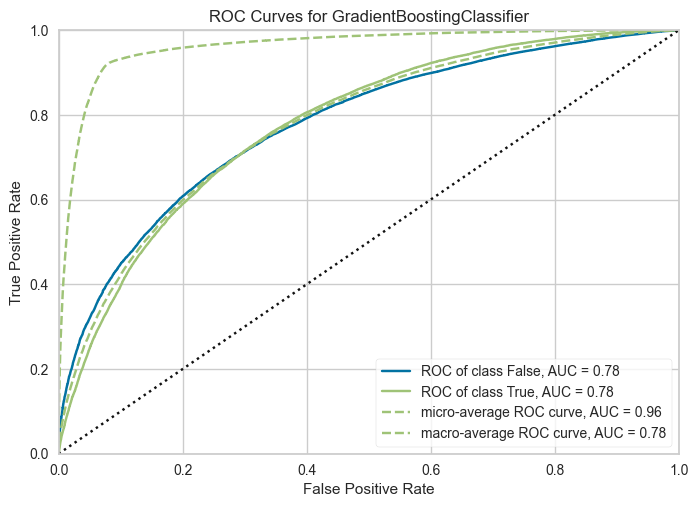

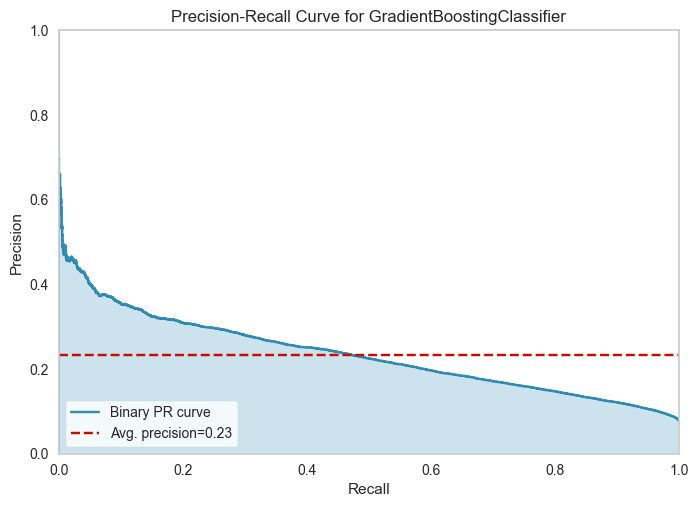

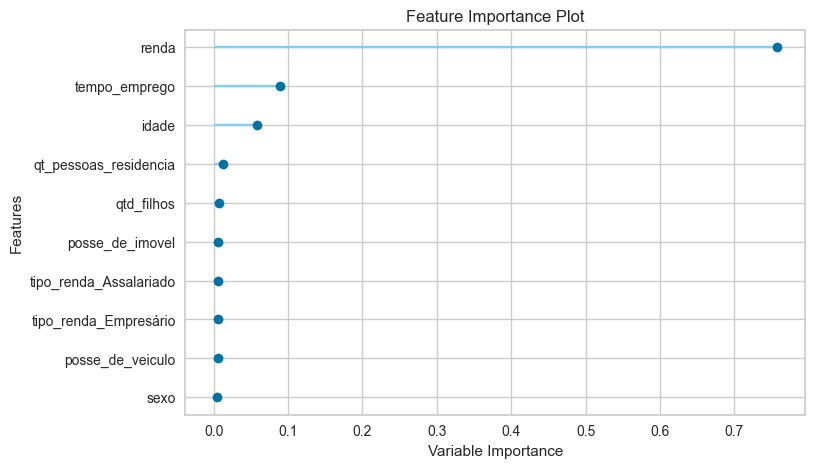

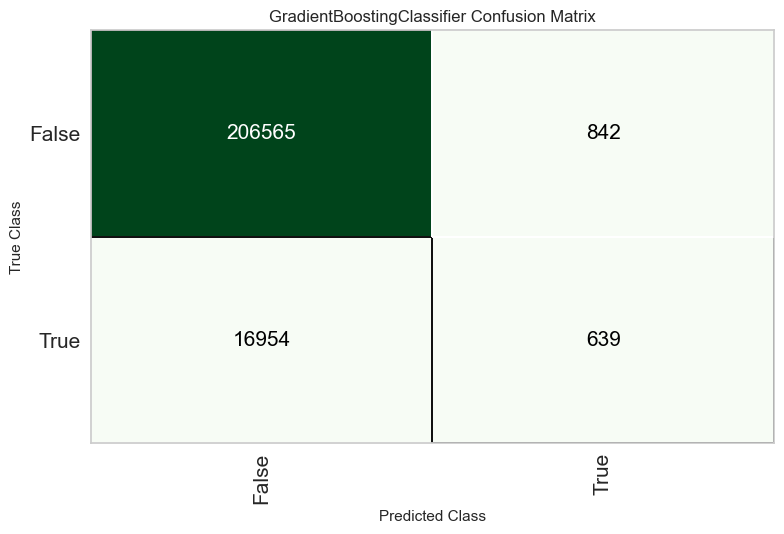


Avaliando o modelo:


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.9209,0.7786,0.0363,0.4315,0.0670,0.0555,0.1071



Resultado antes da finalização do modelo:
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.3, loss='log_loss', max_depth=5,
                           max_features=1.0, max_leaf_nodes=None,
                           min_impurity_decrease=0.0005, min_samples_leaf=3,
                           min_samples_split=7, min_weight_fraction_leaf=0.0,
                           n_estimators=160, n_iter_no_change=None,
                           random_state=123, subsample=0.45, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

Resultado do modelo finalizado:
Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['qtd_filhos', 'idade',
                                             'tempo_emprego',
                                          

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.9252,0.7873,0.0471,0.5982,0.0872,0.0770,0.1528



Acurácia do modelo final (mau): 0.0

Tempo total de execução: 4059.72 segundos


{'modelo final': Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWra...
                                             criterion='friedman_mse',

In [40]:
print("Utilizando a base de dados completa:")
model_pycaret(df, 'mau', data_test)

Percebeu-se uma mudança nos modelos de melhor desempenho conforme o tamanho da base de dados utilizada. O modelo Linear Kernel apresentou melhor performance na base com recorte (sample), enquanto o Gradient Boosting Classifier (GBC) obteve melhor desempenho na base completa. Isso pode ter ocorrido por alguns motivos: (i) a base inteira possui maior variabilidade entre os dados e suas interações, tornando a análise menos linear; (ii) o GBC tende a aproveitar melhor grandes volumes de dados para aprendizado; (iii) esse modelo é mais propenso ao overfitting em bases mais genéricas; e (iv) a base original apresenta desbalanceamento entre as classes de “mau pagador”.

Comparando as duas fontes de dados, com a mesma quantidade de folds e a análise dos respectivos modelos de melhor desempnheo temos os seguintes dados resultates, como esperado, o modelo treinado com a base completa apresentou melhor resultado preditivo, com aumento de acurácia de 0,11, aproximadamente. No entanto, houve também um aumento de 3690% no tempo de processamento. Dessa forma, considerando o contexto desta análise e o recorte utilizado para a amostra, pode-se concluir que o uso da base completa, embora mais preciso, torna-se moroso e pesado, sendo recomendado apenas em casos em que ganhos preditivos justificam o custo computacional.